In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import random
import cv2
import matplotlib.pyplot as plt 
from collections import Counter
from PIL import Image
import matplotlib.image as mpimg
import os
import random
from torchvision import models
import pickle

In [2]:
! pwd

/home/ec2-user/whales2


In [3]:
PATH = Path('/home/ec2-user/whales2/')

In [4]:
list(PATH.iterdir())

[PosixPath('/home/ec2-user/whales2/Model Exploration-Resnet50-Better-Copy1.ipynb'),
 PosixPath('/home/ec2-user/whales2/resnet152'),
 PosixPath('/home/ec2-user/whales2/.ipynb_checkpoints'),
 PosixPath('/home/ec2-user/whales2/train.csv'),
 PosixPath('/home/ec2-user/whales2/sample_submission.csv (1).zip'),
 PosixPath('/home/ec2-user/whales2/train-300'),
 PosixPath('/home/ec2-user/whales2/deepsense-whales'),
 PosixPath('/home/ec2-user/whales2/deepsense-whales.zip'),
 PosixPath('/home/ec2-user/whales2/sample_submission.csv'),
 PosixPath('/home/ec2-user/whales2/mode_tmp.pth'),
 PosixPath('/home/ec2-user/whales2/valid-300'),
 PosixPath('/home/ec2-user/whales2/imgs_subset'),
 PosixPath('/home/ec2-user/whales2/Untitled.ipynb'),
 PosixPath('/home/ec2-user/whales2/imgs'),
 PosixPath('/home/ec2-user/whales2/test-300'),
 PosixPath('/home/ec2-user/whales2/Train_Valid_Split.ipynb'),
 PosixPath('/home/ec2-user/whales2/Resnet152.ipynb')]

In [5]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

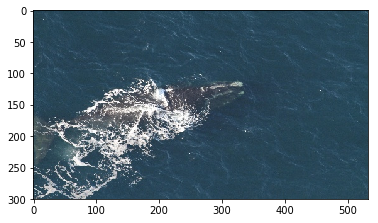

In [6]:
path = PATH/"test-300/w_3206.jpg"
im = read_image(path)
plt.imshow(im)

# Data Augmentation

In [7]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def horizontal_flip(im):
    return np.fliplr(im)

def gray_scale(im):
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    return np.stack((im,)*3, -1) #keep image as 3 channels (it has 3 copies of same layer)

# Train Valid Split

In [8]:
df = pd.read_csv('/home/ec2-user/whales2/train.csv')

In [9]:
sample = pd.read_csv('/home/ec2-user/whales2/sample_submission.csv')

In [12]:
sample.columns[1:]

Index(['whale_00195', 'whale_00442', 'whale_02411', 'whale_02608',
       'whale_02839', 'whale_03103', 'whale_03227', 'whale_03623',
       'whale_03728', 'whale_03935',
       ...
       'whale_98618', 'whale_98633', 'whale_98645', 'whale_98746',
       'whale_98939', 'whale_98996', 'whale_99243', 'whale_99326',
       'whale_99558', 'whale_99573'],
      dtype='object', length=447)

In [13]:
# this will give us what we need to add the encoded y
y_id_to_num = {}
y_num_to_id = {}
uniq_y = sample.columns[1:] #this way they are in order of needed submission
for i in range(len(uniq_y)):
    y_id_to_num[uniq_y[i]] = i
    y_num_to_id[i] = uniq_y[i]

# add an encoded version of the y to dataframe
df['y'] = df["whaleID"].map(y_id_to_num)
#dictionary of image name to label
name_id_dict = dict( zip( df["Image"], df["y"]))

In [16]:
len(uniq_y)

447

In [17]:
train_files = list((PATH/"train-300").iterdir())
y_train = [name_id_dict[p.parts[-1]] for p in train_files]

In [18]:
valid_files = list((PATH/"valid-300").iterdir())
y_valid = [name_id_dict[p.parts[-1]] for p in valid_files]

In [19]:
len(train_files), len(y_train)

(3631, 3631)

In [20]:
len(valid_files), len(y_valid)

(912, 912)

# Dataset

In [21]:
def resize_images_ratio(im, sz=300, r=1.5):
    sz2 = int(r*sz)
    return cv2.resize(im, (sz2, sz))

In [22]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [23]:
class WhalesDataset(Dataset):
    #only storing where images are
    def __init__(self, filenames, y, sz=280, transforms=False):
        self.transforms = transforms
        self.sz = sz
        self.sz2 = int(sz*1.75)
        self.files = filenames
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        path = str(self.files[idx])
        # scaling
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg) 
            if np.random.random() > 0.5: x = horizontal_flip(x).copy() #flip with prob 0.5
            if np.random.random() > 0.5: x = gray_scale(x).copy()
            x = random_crop(x, self.sz, self.sz2)
        else:
            x = resize_images_ratio(x, self.sz)
        x = normalize(x) 
        return np.rollaxis(x, 2), self.y[idx]

In [24]:
train_ds = WhalesDataset(train_files, y_train, transforms=True)
val_ds = WhalesDataset(valid_files, y_valid)

In [25]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size)

# Resnet 152 Model

In [22]:
resnet = models.resnet152(pretrained=True)

In [23]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AvgPool2d(kernel_size=7, stride=1, padding=0),
 Linear(in_features=2048, out_features=1000, bias=True)]

In [24]:
list(resnet.children())[9]

Linear(in_features=2048, out_features=1000, bias=True)

In [26]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        resnet = models.resnet152(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:9] #gets the first 7 layers from resnet dont wnat last two
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.fc1 = nn.Linear(2048, 2048)
        self.fc2 = nn.Linear(2048, 447) 
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [54]:
model = Resnet().cuda()

In [55]:
x, y = next(iter(train_dl))

In [56]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([64, 3, 280, 490])

In [57]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 447])

# Triangular Training Loop

In [27]:
def get_optimizer(model, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [24]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-15, lr_high=.5, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda().float() #.unsqueeze(1)
            out = model(x)
            loss = F.cross_entropy(out, y.long())
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses

In [60]:
resnet = Resnet().cuda()
lrs, losses = LR_range_finder(resnet, train_dl)

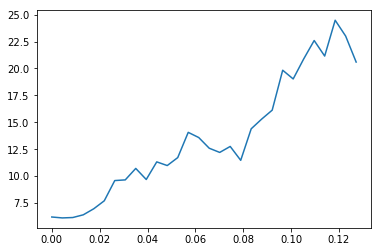

In [61]:
plt.plot(lrs[:30], losses[:30])
plt.show()

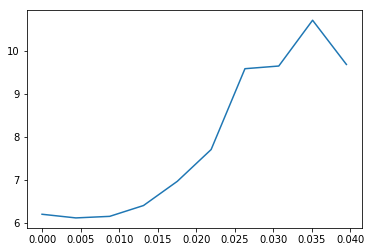

In [62]:
plt.plot(lrs[:10], losses[:10])
plt.show()

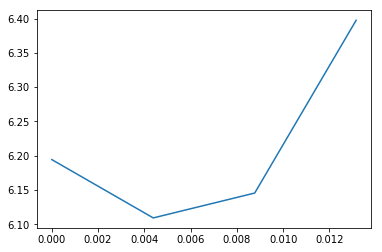

In [71]:
plt.plot(lrs[:4], losses[:4])
plt.show()

In [25]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [26]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-15, lr_high=0.01):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
            
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float() #.unsqueeze(1)
            out = model(x)
            loss = F.cross_entropy(out, y.long())
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total

In [27]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda() #.unsqueeze(1)
        out = model(x)
        pred = (out > 0.0).long()
        y = y.float()
        loss = F.cross_entropy(out, y.long())
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss: ", sum_loss/total)

In [28]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.01):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [29]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(val_ds, batch_size=batch_size)

In [30]:
resnet = Resnet().cuda()

In [31]:
val_metrics(resnet, valid_dl)

val loss:  6.105112912362082


In [32]:
training_loop(resnet, train_dl, valid_dl,lr_low=.00001, lr_high=.004)

train loss 6.083240295106536
val loss:  6.120715149661951
train loss 5.97424775252031
val loss:  5.969302311278226
train loss 5.740474491072108
val loss:  5.939073194537246
train loss 5.6581377968647635
val loss:  5.938086225275407
----End of step Time elapsed 0:19:58.098638
train loss 5.704607954894633
val loss:  5.987627004322253
train loss 5.79072995581137
val loss:  5.999100559636166
train loss 5.6733292432830735
val loss:  5.931731341177957
train loss 5.602486282759414
val loss:  5.931277141236422
----End of step Time elapsed 0:19:58.074022
train loss 5.636925407363442
val loss:  6.0323513348897295
train loss 5.750109864804608
val loss:  5.990655045760305
train loss 5.639226576606291
val loss:  5.96543158146373
train loss 5.568445674908848
val loss:  5.930379984671609
----End of step Time elapsed 0:19:57.744995


In [34]:
pickle.dump(resnet, open('resnet152', 'wb'))

# Getting Predictions

In [30]:
resnet = pickle.load(open('resnet152', 'rb'))

In [31]:
class WhalesDatasetTest(Dataset):
    #only storing where images are
    def __init__(self, filenames, sz=280):
        self.sz = sz
        self.sz2 = int(sz*1.75)
        self.files = filenames
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = str(self.files[idx])
        # scaling
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        x = resize_images_ratio(x, self.sz)
        x = normalize(x) 
        return np.rollaxis(x, 2)

In [32]:
test_files = list((PATH/"test-300").iterdir())
test_ds = WhalesDatasetTest(test_files)

batch_size = 64
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [33]:
def final_pred(model, test_dl=test_dl):
    model.eval()
    predictions = []
    for x in test_dl:
        batch = x.shape[0]
        x = x.cuda().float()
        
        pred = model(x)
        predictions.append(pred)
    return predictions

In [34]:
predictions = final_pred(resnet)

In [35]:
final_predictions = [] #get predictions out of nested batch form
for pred in predictions:
    for p in pred:
        probs = nn.functional.softmax(p).detach().cpu().numpy()
        final_predictions.append(probs)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [58]:
df = pd.DataFrame(final_predictions, columns=sample.columns[1:])

In [41]:
img_names = [p.parts[-1] for p in test_files]

In [60]:
df['Image'] = img_names

In [62]:
df.to_csv('pred_resnet152', index=False)

In [63]:
len(train_files)

3631

In [64]:
len(valid_files)

912

In [65]:
3631+912

4543